# Target is Image denoising and remove noise from a noisy image, so as to restore the true image
* CIFAR10 dataset
* Image is grayscale of size 48*48

# Importing libraries

In [1]:
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd# Any results you write to the current directory are saved as output.
from IPython.display import display, Image
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
import tensorflow as tf
# Setting the figure size for matplotlib
rcParams['figure.figsize'] = 20, 10
# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

### Loading CIFAR-10 dataset using tf.keras.datasets.cifar10 which can be downlaoded slso as well

In [2]:
(X_train,Y_train),(X_test, Y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
X_train.shape

(50000, 32, 32, 3)

# Data Preprocessing

# noise factor: 0.07
* that mean in the 0.07 persent of picxal i will add salt and pepper noise

In [4]:
#NOrmalizing the images
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.07

from skimage.util import random_noise

#noisy = random_noise(img, mode="poisson")
#just change the mode pf the noise to-->'gaussain', 
x_train_noisy = random_noise(x_train, mode="s&p",clip=True, amount=noise_factor)
x_test_noisy = random_noise(x_test, mode="s&p",clip=True, amount=noise_factor)

# Taking 100 images seperate for final testing

In [5]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

# Visualization of 10 Data

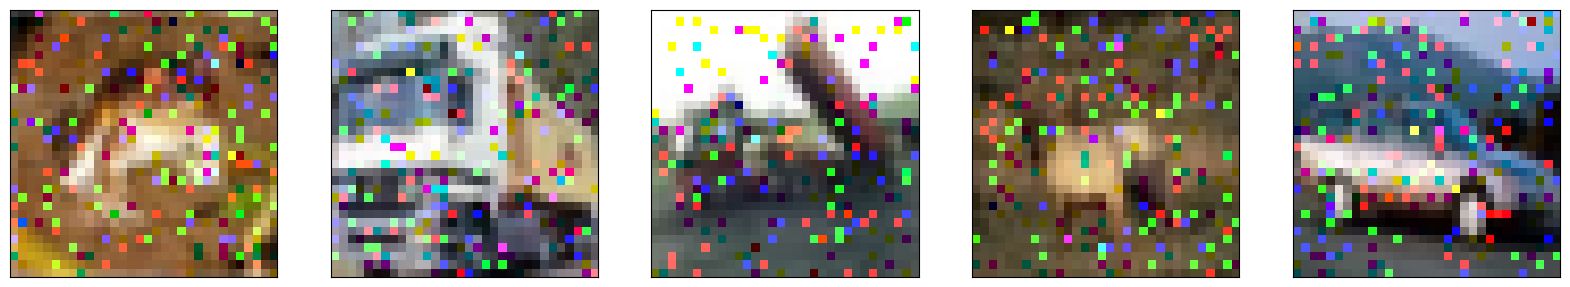

In [6]:
n = 5
plt.figure(figsize=(20, 20))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Construction of Model

In [7]:
# Function to define a U-Net model for image segmentation
def UNet_model(input_layer, start_neurons):
    # Contracting path
    conv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(input_layer)
    conv1 = Conv2D(start_neurons*1, (3,3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    conv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    conv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.25)(pool3)
    
    conv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(pool4)
    convm = Conv2D(start_neurons * 16, (3,3), activation='relu', padding='same')(convm)
    
    # Expansive path
    # Up-convolution (deconvolution) followed by concatenation and convolution
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3,3), activation='relu', padding='same')(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3,3), activation='relu', padding='same')(uconv3)
    
    deconv2 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3,3), activation='relu', padding='same')(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons*3, (3,3), activation='relu', padding='same')(uconv1)
    uconv1 = Conv2D(start_neurons*3, (3,3), activation='relu', padding='same')(uconv1)
    
    # Output layer with 3 channels and sigmoid activation
    output_layer = Conv2D(3, (1,1), padding='same', activation='sigmoid')(uconv1)
    
    return output_layer


In [8]:
#Defining target image size and Input size and building model
img_size_target = 32
input_layer = Input((img_size_target, img_size_target,3))
output_layer = UNet_model(input_layer,64)

In [9]:
#Initializing and compiling model
model_unet = Model(input_layer, output_layer)
model_unet.compile(optimizer='adam', loss='MSE')

# U-NET Summary

In [10]:
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Training Model

In [11]:
model_unet.fit(x_train_noisy, x_train,
                epochs=3,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/3

  6/782 [..............................] - ETA: 1:01:05 - loss: 0.0544

## Making Prediction

In [ ]:
predict = model_unet.predict(x_test_final_noisy)

4/4 [==============================] - 2s 362ms/step


# Visualizing the prediction

## Original Test images

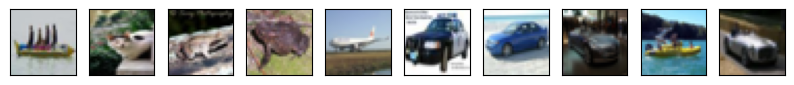

In [ ]:
n=10
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_original[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Noised Test images

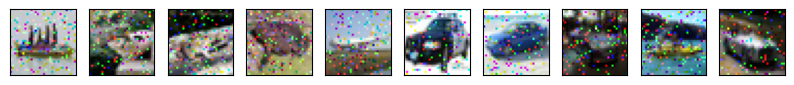

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_noisy[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generated Test images

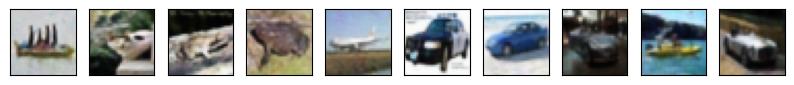

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# U-NET: Train Loss VS validation loss
becouse I don't have time for enother ephoc i don't have available keys in history and then it can't show any plot but generated test images we can see how good it have denoised images

In [ ]:
# Assuming model_unet is your UNet model
print("Available keys in history:", model_unet.history.history.keys())

# Plotting the training and validation loss if available
if 'loss' in model_unet.history.history and 'val_loss' in model_unet.history.history:
    epochs = range(1, 2)  # Since you mentioned one epoch
    plt.plot(epochs, model_unet.history.history['loss'], 'r-o', label='Training Loss')
    plt.plot(epochs, model_unet.history.history['val_loss'], 'b-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Loss information not found in the training history.")

Available keys in history: dict_keys([])
Loss information not found in the training history.


In [ ]:
# Assuming model_unet is your UNet model
if 'loss' in model_unet.history.history and 'val_loss' in model_unet.history.history:
    epochs = range(1, len(model_unet.history.history['loss']) + 1)
    plt.plot(epochs, model_unet.history.history['loss'], 'r-o', label='Training Loss')
    plt.plot(epochs, model_unet.history.history['val_loss'], 'b-o', label='Validation Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Loss information not found in the training history.")

Loss information not found in the training history.
